In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

In [158]:

# 1. Load Shiller's CAPE data
df = pd.read_excel('ie_data.xlsx', sheet_name='Data', skiprows=7)

In [149]:
df

,Date_org,CAPE,Price,Earnings,10Y Excess Return,1Y Excess Return,1M Excess Return,3M Excess Return,Year,Month,EP,Return_10Y,Return_1Y,Return_1M
Date,,,,,,,,,,,,,,
1900-01-01,1900.01,18.674275,247.439742,19.470668,0.068764,0.015688,0.001791,0.003899,1900,1,0.053550,0.318787,0.187635,0.005914
1900-02-01,1900.02,18.703797,248.903085,19.238886,0.063132,0.016616,0.000814,-0.002707,1900,2,0.053465,0.264211,0.225845,0.008052
1900-03-01,1900.03,18.775793,250.907136,19.238886,0.064850,0.019535,0.001289,-0.006483,1900,3,0.053260,0.260838,0.259664,0.012780
1900-04-01,1900.04,18.936402,254.113617,19.238886,0.060925,0.026660,-0.004805,-0.007682,1900,4,0.052808,0.203573,0.365172,-0.024083
1900-05-01,1900.05,18.403197,247.993894,19.708124,0.064365,0.026350,-0.002960,-0.001446,1900,5,0.054338,0.236072,0.328402,-0.017823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-01,2015.01,26.492295,2779.979160,138.835847,0.129274,-0.003700,0.003538,0.003779,2015,1,0.037747,NaN,NaN,0.022195
2015-02-01,2015.02,26.995514,2841.681567,136.843440,0.124920,-0.010718,0.000431,0.003389,2015,2,0.037043,NaN,NaN,-0.006972
2015-03-01,2015.03,26.728605,2821.870483,134.649996,0.116350,-0.004159,-0.000190,0.003759,2015,3,0.037413,NaN,NaN,0.005106


In [159]:

# Clean up
df = df[['Date', 'CAPE', 'Real Price', 'Real Earnings', '10Y Excess Return', '1Y Excess  Return', '1M Excess Return', '3M Excess Return', '1Y Annualized Bonds Real Return']]
df = df.dropna()
df.columns = ['Date_org', 'CAPE', 'Price', 'Earnings', '10Y Excess Return', '1Y Excess Return', '1M Excess Return', '3M Excess Return', '1Y Bond Return']
df['Year'] = df['Date_org'].astype(int)  # Extract the integer part as the year
df['Month'] = ((df['Date_org'] - df['Year']) * 100).round(0).astype(int)  # Extract the fractional part and convert to month
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')
df.set_index('Date', inplace=True)
df = df[df.index >= '1900-01-01']

In [161]:
# Calculate E/P
df = df[df['CAPE'] != 0]  # Filter out rows where CAPE is zero
df['EP'] = 1 / df['CAPE']

# Calculate future returns
df['Return_10Y'] = df['Price'].shift(-120) / df['Price'] - 1
df['Return_1Y'] = df['Price'].shift(-12) / df['Price'] - 1
df['Return_1M'] = df['Price'].shift(-1) / df['Price'] - 1

df_reg = df.dropna(subset=['Return_10Y', 'Return_1Y', 'Return_1M', 'EP', '10Y Excess Return', '1Y Excess Return', '1M Excess Return', '3M Excess Return'])

# Run OLS regression with Newey-West standard errors
def run_regression(y, x):
    try:
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
        return {
            'Beta': model.params[1],
            'T-stat': model.tvalues[1],
            'R-squared': model.rsquared
        }
    except Exception as e:
        return {'Beta': None, 'T-stat': None, 'R-squared': None}

# Table 1
results = {
    'Next 10Y': run_regression(df_reg['10Y Excess Return'], df_reg['EP']),
    'Next 1Y': run_regression(df_reg['1Y Excess Return'], df_reg['EP']),
    'Next 1M': run_regression(df_reg['1M Excess Return'], df_reg['EP']),
}
results_df = pd.DataFrame(results).T.round(2)
print("Table 1 - Regression Summary")
print(results_df)


Table 1 - Regression Summary
          Beta  T-stat  R-squared
Next 10Y  0.72   12.58       0.20
Next 1Y   0.12    4.54       0.04
Next 1M   0.01    0.94       0.00


/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_93468/4270177158.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Beta': model.params[1],
/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_93468/4270177158.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'T-stat': model.tvalues[1],
/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_93468/4270177158.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Bin Borders: [ 4.78424105 10.32934892 12.93588238 16.65924919 20.81645722 44.19793976]


/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_93468/1813486179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['CAPE_bin'], bin_borders = pd.qcut(df_reg['CAPE'], 5, labels=['5 (Cheapest)', '4', '3', '2', '1 (Richest)'], retbins=True)
/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_93468/1813486179.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_reg.groupby('CAPE_bin')[['10Y Excess Return']].mean() * 100  # Percent


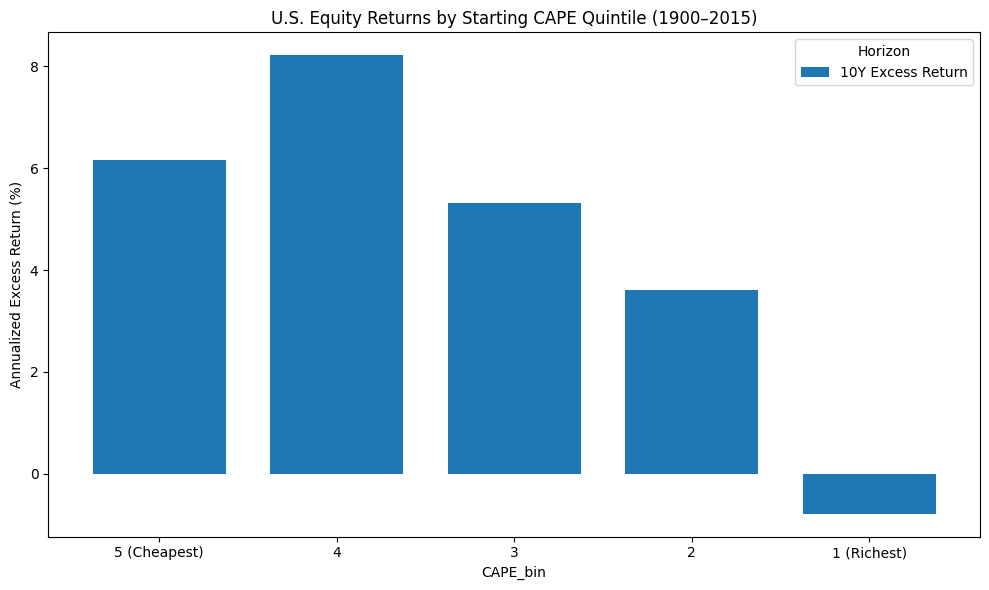

In [116]:
# Bin data into quintiles based on CAPE (low CAPE = cheap)
df_reg['CAPE_bin'], bin_borders = pd.qcut(df_reg['CAPE'], 5, labels=['5 (Cheapest)', '4', '3', '2', '1 (Richest)'], retbins=True)
print("Bin Borders:", bin_borders)

# Compute average excess returns by CAPE bin
grouped = df_reg.groupby('CAPE_bin')[['10Y Excess Return']].mean() * 100  # Percent

# Plot charts
grouped.plot(kind='bar', figsize=(10, 6), width=0.75)
plt.title("U.S. Equity Returns by Starting CAPE Quintile (1900–2015)")
plt.ylabel("Annualized Excess Return (%)")
plt.xticks(rotation=0)
plt.legend(title="Horizon")
plt.tight_layout()
plt.show()

In [ ]:
df['rolling_cape'] = df['CAPE'].rolling(window=240, min_periods=200).mean()


In [142]:
window_size = 240  # 60 years × 12 months
rolling_data = []

for i in range(len(df) - window_size):
    window = df.iloc[i:i + window_size]
    start_date = window.index[0]
    start_cape = window['CAPE'].iloc[0]

    # Annualized average excess return over 10 years from start
    # Use log returns for stability
    returns_10Y = window['10Y Excess Return'].dropna().mean()
    returns_1Y = window['1Y Excess Return'].dropna().mean()
    returns_3M = window['3M Excess Return'].dropna().mean()


    rolling_data.append({
        'Start_Date': start_date,
        'Start_CAPE': start_cape,
        '10Y Excess Return': returns_10Y,
        '1Y Excess Return': returns_1Y,
        '3M Excess Return': returns_3M,
    })

rolling_df = pd.DataFrame(rolling_data)

# Step 3: Bin by starting CAPE into quintiles
rolling_df['CAPE_bin'], bin_borders_roll = pd.qcut(rolling_df['Start_CAPE'], 5, labels=['5', '4', '3', '2', '1'], retbins=True)
print("Rolling Bin Borders:", bin_borders_roll)

# Step 4: Calculate average excess return by CAPE bin
bin_summary = rolling_df.groupby('CAPE_bin').mean().reset_index()

# Optional: display result
print(bin_summary)

Rolling Bin Borders: [ 4.78424105 10.00004656 12.28847038 15.47478362 18.8882444  32.5637886 ]
  CAPE_bin                    Start_Date  Start_CAPE  10Y Excess Return  \
0        5 1948-03-06 11:56:51.353711744    8.103763           0.041582   
1        4 1945-03-05 02:05:45.851528448   11.213531           0.061432   
2        3 1940-01-03 14:21:29.082969472   13.813445           0.053774   
3        2 1953-08-25 23:09:41.659388672   17.266789           0.045494   
4        1 1951-04-26 12:09:25.938864640   21.526201           0.041525   

   1Y Excess Return  3M Excess Return  
0          0.004735          0.001219  
1          0.007261          0.001797  
2          0.005489          0.001379  
3          0.003792          0.000918  
4          0.002663          0.000631  


/var/folders/pk/1f2_609s7cl4sjxfyj9b_s6m0000gn/T/ipykernel_93468/844563305.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = rolling_df.groupby('CAPE_bin').mean().reset_index()


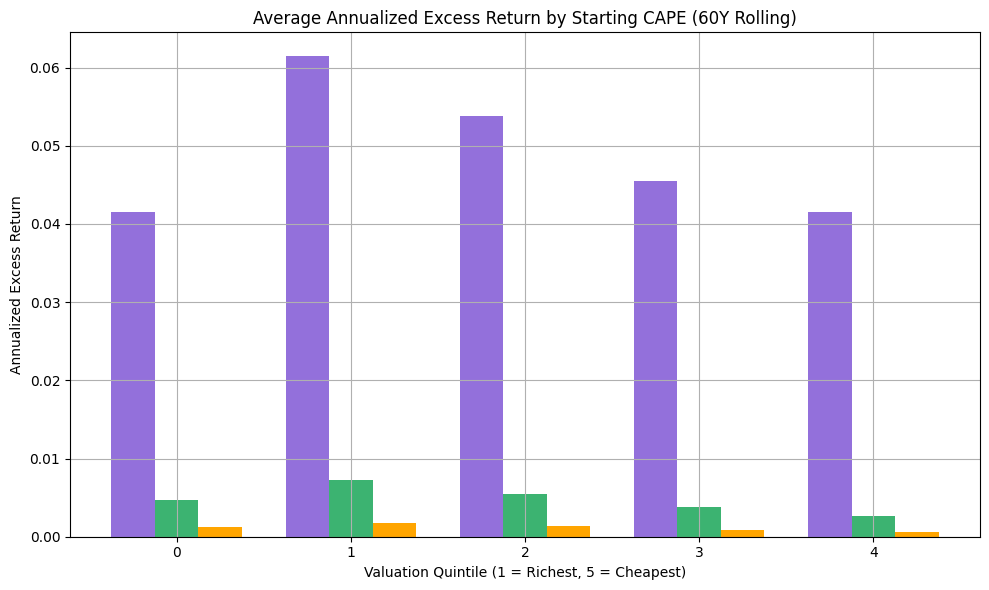

In [147]:
bar_width = 0.25
x = np.arange(len(bin_summary['CAPE_bin']))

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, bin_summary['10Y Excess Return'], width=bar_width, label='10-Year', color='mediumpurple')
plt.bar(x, bin_summary['1Y Excess Return'], width=bar_width, label='1-Year', color='mediumseagreen')
plt.bar(x + bar_width, bin_summary['3M Excess Return'], width=bar_width, label='3-Month', color='orange')

plt.title('Average Annualized Excess Return by Starting CAPE (60Y Rolling)')
plt.xlabel('Valuation Quintile (1 = Richest, 5 = Cheapest)')
plt.ylabel('Annualized Excess Return')
plt.grid(True)
plt.tight_layout()
plt.show()

In [162]:

# 3. Strategy: market timing using CAPE
rolling_window = 240  # 20 years of monthly data
df['median_EP'] = df['EP'].rolling(rolling_window).median()
df['range_EP'] = df['EP'].rolling(rolling_window).quantile(0.95) - df['EP'].rolling(rolling_window).quantile(0.05)

# Compute tactical weights
df['signal'] = 100 + 100 * ((df['EP'] - df['median_EP']) / df['range_EP'])
df['weight'] = df['signal'].clip(lower=50, upper=150) / 100  # Clip to 50%-150%

# Strategy return
df['cash_return'] = df['1Y Bond Return'] # Approx. 1M LIBOR ~0.1% annualized
df['strategy_return'] = df['weight'].shift(1) * df['1Y Excess Return'].fillna(0) + (1 - df['weight'].shift(1)) * df['cash_return']

In [163]:

# 4. Buy-and-hold benchmark
df['buy_hold'] = df['1Y Excess Return'].fillna(0)

In [164]:

# 5. Cumulative returns
df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buyhold_cum'] = (1 + df['buy_hold']).cumprod()

In [169]:
print(df['strategy_return'].mean()*100)
print(df['buy_hold'].mean()*100)

0.5639715256945301
0.4575071408394328


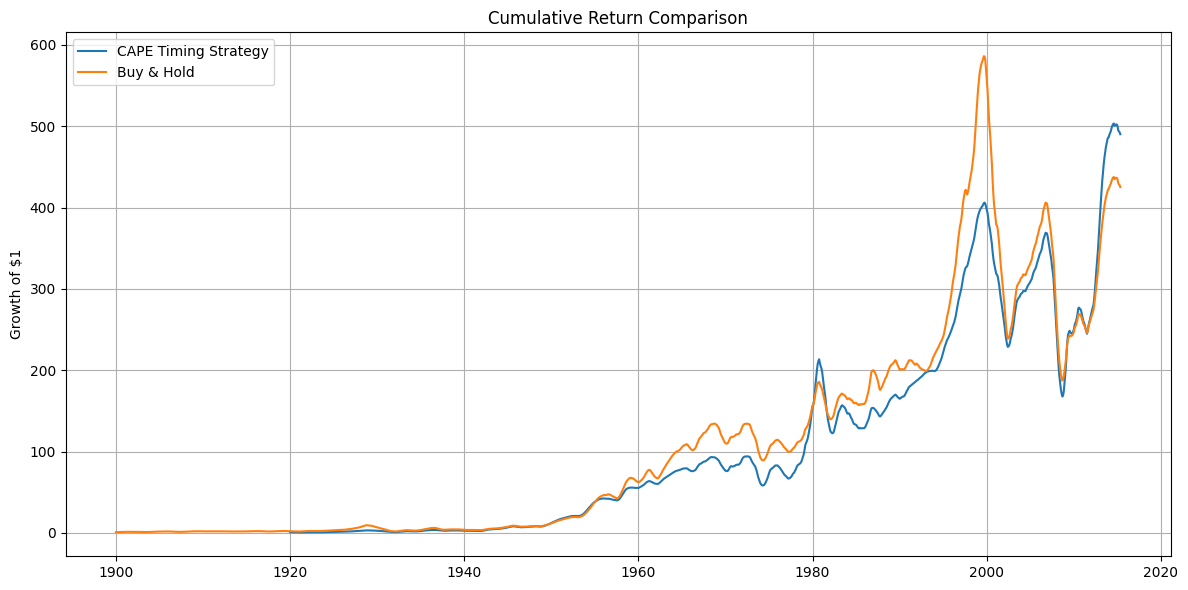

In [165]:

# 6. Plot
plt.figure(figsize=(12, 6))
plt.plot(df['strategy_cum'], label='CAPE Timing Strategy')
plt.plot(df['buyhold_cum'], label='Buy & Hold')
plt.title('Cumulative Return Comparison')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [166]:

# Final comparison
final_vals = df[['strategy_cum', 'buyhold_cum']].dropna().iloc[-1]
print("\nFinal Cumulative Return:")
print(f"Strategy: {final_vals['strategy_cum']:.2f}x")
print(f"Buy & Hold: {final_vals['buyhold_cum']:.2f}x")



Final Cumulative Return:
Strategy: 490.26x
Buy & Hold: 425.30x
